# 张量网络压缩采样

> Reference:
> * _Tensor network compressed sensing with unsupervised machine learning_
> * 《张量网络》第 6 章第 8 节

张量网络压缩采样也称张量网络压缩感知 (Tensor network compressed sensing)

## 压缩采样

核心思想：是指尽量在不损失准确性的前提下，以尽可能小的采样次数对完整的信号（例如图像）进行重构，从而提升效率。

应用：核磁共振、雷达、遥感等。

> 例：水质探测
> 
> 考虑对一段河流的水质进行监测，假设被监测区域的面积为1000m×1000m，而现有探测器的检测范围为10m×10m，那么原则上需要100×100=10000个探测器，才能完全覆盖整个监测区域。
> 
> 但实际上，水质的好坏对于空间位置而言是相对连续的，因此在实际情况下，我们并不需要完全覆盖整个区域也能获得对水质的准确信息。同时，用于河流本身的特点，例如河底的地貌、水流速度、排水口、游船航线、钓鱼区等的位置，会对水质造成不同程度的影响，因此不同位置的探测结果与整体水质之间的"相关性"也是有区别的。
> 
> 假设我们仅有L≪10000个探测器，那么面临的问题则是：在什么位置放置探测器才能最准确的重构整体的水质信息？
>

### 压缩采样与特征选择

* 压缩采样是对采样或测量的压缩，我们可以将测量所得的信息当作是机器学习中的特征，来认识二者间的联系与区别。
* 如果我们只考虑为整体水质打一个的"评分"或给一个"好中差"的评价，这相当于一个回归或分类问题，我们需要做的则是选择出能够帮助我们准确预测评分或分类的最重要的那一部分特征，这可被认为是一种典型的特征选择任务。
* 如果我们考虑的不是简单给一个评分，而是重构出整个水域不同位置处的水质，则上述问题可被认为是一个典型的压缩采样问题。

联系：选出重要的测量或者特征

区别：预测任务或者重构任务

### 张量网络压缩采样 (TNCS) 的数学描述

基本思想：以特征选择中类似的方式利用单点纠缠熵，选择出对重构任务最为重要的特征

数学描述：设每个样本中包含 $L$ 个特征，例如在上述水质采样的例子中，我们有 $L = 10000$，这是完全覆盖监测水域所需的探测器个数，而各个特征的取值为探测器的读数。TNCS的目的是通过采样获得 $\hat{L}$ 个特征的值（将这些特征位置构成的集合记为 $\mathcal{A}$），来可靠地重构出 $(L-\hat{L})$ 个未知特征（对应位置的集合记为 $\mathcal{B}$）。

与经典压缩采样类似，在数据存在稀疏性与非相干性的前提下，采样的特征数 $\hat{L}$ 可以远远小于 $L$，且可远小于传统重构方法所要求的特征数量。

> 经典压缩采样参考：https://zhuanlan.zhihu.com/p/22445302

针对GMPS，对应的问题具体可被描述为：在已获得GMPS的情况下，如何选择L个特征（比特位），使得在已知这些特征取值的情况下，我们能够精确地获得其余特征的取值。

### 张量网络压缩采样 (TNCS) 的量子通信的语言描述

假设 Alice 与 Bob 之间想要利用GMPS建立一种量子通讯协议，用于传输某一类信息，例如将河水的水质数据由 Alice 通过量子通讯传输给 Bob 。

* 制备GMPS与采样规则通信：他们首先利用已有的水质数据训练GMPS，并制备出对应的纠缠态，并将该态交由 Bob ，并事先约定好特定的测量位置与顺序，即确定$A$。
* 经典通信：当 Alice 想要将某水质信息传输给 Bob 时，她只需将$A$对应的数据通过经典信道（classical channel，例如发邮件）传输给 Bob 。
* 量子测量与后选择： Bob 拿到这些数据后，按照约定的顺序对GMPS中这部分对应的量子位进行投影测量。注意由于测量的结果是随机的，而 Bob 需要在测量$A$对应的量子位后，获得与 Alice 所传数据一致的测量结果。因此， Bob 需要准备多个GMPS并对其进行测量，测量后选择出与 Alice 所传数据一致的结果，这在量子计算中被称为后选择（post-selection）。
* 生成与重构：最后， Bob 利用后选择出的量子态，对未传输的$B$对应的数值进行生成，从而重构出整个水质数据。
* 安全性：由于具体数据的通信中， Alice 与 Bob 并不需要就GMPS本身以及测量位置、顺序进行通讯，这些信息只需在最开始的时候传输，类似于量子信道（quantum channel）的建立过程。在之后对具体数据进行传输时，他们仅需传输$A$对应的数据，因此可以认为GMPS以及测量位置、顺序并不会被泄露，由GMPS生成获得的$B$对应的特征数据是通过量子信道传输的，是安全的。

![tncs_steps](./images/tncs_steps.png)

### 通过单点纠缠熵压缩采样及其不足之处

确定$\mathcal{A}$的基本思想：使得在$\mathcal{A}$中特征数量尽可能少的情况下，让鲍勃能够准确地恢复未传输的$\mathcal{B}$中的数据。

直接采用基于OEE的特征选择方法：选择由GMPS给出的OEE最大的那部分特征构成$\mathcal{A}$，来生成其余特征的取值。

基于OEE的特征选择在这个问题上并非最优：
  
考虑由两个样本[1, 0, 0]与[0, 1, 0]构成的数据集，其懒惰态为$|\Phi\rangle = \frac{1}{\sqrt{2}}(|10\rangle + |01\rangle)|0\rangle$。易得，该态的单点纠缠熵为$S_0 = S_1 = \ln 2$，$S_2 = 0$，根据特征选择方法可知，前两个特征为重要特征。但是考虑到我们的任务是以尽可能少量的特征生成其余未知特征，显然，前两个比特位处于最大纠缠态，当我们已知编号0像素的取值时，编号1像素的取值也就确定下来了。因此，我们只需要向鲍勃传输其中一个特征即可，而不需要同时传输这两个特征。

### 基于纠缠次序采样协议 (Entanglement-Ordered Sampling Protocal - EOSP)

伪代码：

初始化 $|\psi_0\rangle = |\psi\rangle$

1. 计算量子态$|\psi_t\rangle$ 的单点纠缠熵OEE $\{S_i\}$, 选择出OEE最大的比特位，并记录其位置 $\tilde{i_t}$，有 $\tilde{i_t} = \text{argmax}_i(S_i)$;
2. 计算比特位 $\tilde{i_t}$ 对应的单点约化密度矩阵 $\tilde{\rho} = \text{Tr}_{/\tilde{i_t}}|\psi_t\rangle\langle\psi_t|$，其中 $\text{Tr}_{/\tilde{i_t}}$ 代表对除 $\tilde{i_t}$ 外的其余所有比特位进行求迹运算，并计算 $\tilde{\rho}$ 的最大本征态（记为$|v_t\rangle$）;
3. 选择测量基底 $\{|v_t\rangle\langle v_t|, |w_t\rangle\langle w_t|\}$（注意有$|v_t\rangle\langle v_t| + |w_t\rangle\langle w_t| = \hat{I}$），对比特位 $\tilde{i_t}$ 进行投影测量，并通过后选择，使该量子位坍缩到 $|v_t\rangle$ 态，坍缩后的态满足 $|\tilde{\psi}_t\rangle = \frac{1}{z}|v_t\rangle\langle v_t|\psi_t\rangle = |v_t\rangle|\psi_{t+1}\rangle$，其中$|\psi_{t+1}\rangle = \frac{1}{z}\langle v_t|\psi_t\rangle$, $z$为归一化因子（注意内积$\langle v_t|\psi_t\rangle$的计算中，投影算符$|v_t\rangle\langle v_t|$ 与量子态 $|\psi_t\rangle$ 中第 $\tilde{i_t}$ 个量子位对应的基矢进行运算，参考第二章第5节的相关内容）;
4. 如果已经记录了 $L$ 个位置，则令 $\mathcal{A} = (\tilde{i_0}, \tilde{i_1},...,\tilde{i_{L-1}})$ 并终止计算，否则回到步骤1。

#### Code

In [1]:
# |default_exp algorithms.entanglement_ordered_sampling_protocal
# |export
import torch
from tensor_network.mps.modules import MPS
from typing import Dict, Any
from tqdm.auto import tqdm

In [2]:
# |export


def _remove_at(tensor: torch.Tensor, idx: int) -> torch.Tensor:
    return torch.cat([tensor[:idx], tensor[idx + 1 :]])


def entanglement_ordered_sampling_protocal(
    mps: MPS,
    select_feautre_num: int | None = None,
    progress_bar_kwargs: Dict[str, Any] = {},
) -> torch.Tensor:
    if select_feautre_num is None:
        select_feautre_num = mps.length
    else:
        assert 0 < select_feautre_num <= mps.length, (
            "select_feautre_num must be less than or equal to mps.length"
        )

    selected_feature_indices = []
    mps_feature_indices = torch.arange(mps.length)
    current_mps = mps

    for _ in tqdm(range(select_feautre_num), **progress_bar_kwargs):
        if len(mps_feature_indices) == 1:
            selected_feature_indices.append(mps_feature_indices[0].item())
        else:
            current_mps.center_orthogonalization_(0, mode="qr", normalize=True)
            oees = current_mps.entanglement_entropy_onsite_()  # (length of current mps,)
            argmax_idx = oees.argmax().item()
            # map the idx of current mps to that of the original mps
            orginal_mps_idx = mps_feature_indices[argmax_idx].item()
            selected_feature_indices.append(orginal_mps_idx)
            # do projection
            rdm = current_mps.one_body_reduced_density_matrix(
                idx=argmax_idx, do_tracing=True, inplace_mutation=True
            )
            eigvals, eigvecs = torch.linalg.eigh(rdm)
            project_to_state = eigvecs[:, eigvals.argmax()]
            current_mps = current_mps.project_one_qubit(argmax_idx, project_to_state)
            # update mapping from the idx of current mps to that of the original mps, since the current mps is projected, yielding a new mps with one less qubit
            mps_feature_indices = _remove_at(mps_feature_indices, argmax_idx)

    return torch.tensor(selected_feature_indices, dtype=torch.long, device=mps.device)

In [3]:
select_feature_num = 200
train_class = 3
test_device = torch.device("cpu")

In [4]:
mps_of_class = MPS.load_from_safetensors(
    f"datasets/mps/mnist_{train_class}_mps.safetensors", requires_grad=False
).to_(device=test_device)

In [5]:
selected_feature_indices = entanglement_ordered_sampling_protocal(mps_of_class, select_feature_num)

  0%|          | 0/200 [00:00<?, ?it/s]

In [6]:
import matplotlib.pyplot as plt

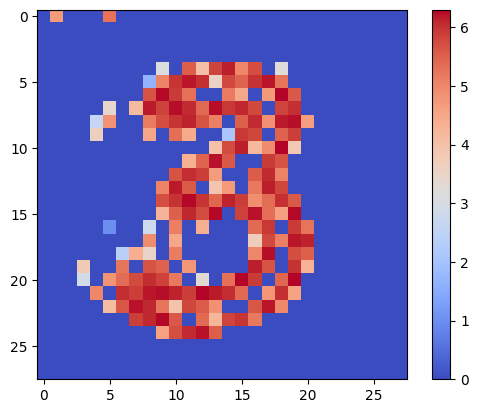

In [7]:
selected_features = torch.zeros(28 * 28, dtype=torch.float32)
# higher rank -> more red -> more important
colors = torch.tensor(range(select_feature_num, 0, -1), dtype=torch.float32).log() + 1.0
selected_features[selected_feature_indices] = colors
selected_features = selected_features.reshape(28, 28)
plt.imshow(selected_features, cmap="coolwarm")
plt.colorbar()
plt.show()